In [0]:
from pyspark.sql import SQLContext
import pyspark
from pyspark.sql.functions import hour, mean, min, col, variance, stddev
import pandas as pd
from pyspark.sql.types import IntegerType, StringType 
from pyspark.sql.functions import row_number, monotonically_increasing_id , lit
from pyspark.sql.window import Window
import math
import matplotlib.pyplot as plt
from pyspark.sql import functions as F
import numpy as np
from scipy.optimize import curve_fit
from scipy import stats
import seaborn as sns 


In [0]:
bkk = spark.sql("SELECT * FROM bkk_weather")
samut = spark.sql("SELECT * FROM samut_prakan")
nont = spark.sql("SELECT * FROM nonthaburi")
npa = spark.sql("SELECT * FROM nakhon_patthom")
bkk_id =  [i for i in range(bkk.count())]
samut_id =  [i for i in range(bkk.count(), samut.count()+bkk.count())]
nont_id =  [i for i in range(samut.count()+bkk.count(), samut.count()+bkk.count()+nont.count())]
npa_id =  [i for i in range(samut.count()+bkk.count()+nont.count(), samut.count()+bkk.count()+nont.count()+npa.count())]

temp = bkk.toPandas()
temp['index'] = bkk_id
bkk = spark.createDataFrame(temp)

temp = nont.toPandas()
temp['index'] = nont_id
nont = spark.createDataFrame(temp)

temp = samut.toPandas()
temp['index'] = samut_id
samut = spark.createDataFrame(temp)

temp = npa.toPandas()
temp['index'] = npa_id
npa = spark.createDataFrame(temp)

bkk = bkk.withColumn("city", lit('Bangkok'))
samut = samut.withColumn("city", lit('Samut Prakan'))
nont = nont.withColumn("city", lit('Nonthaburi'))
npa = npa.withColumn("city", lit('Nakhon Patthom'))

bkk = bkk.union(nont)
bkk = bkk.union(samut)
bkk = bkk.union(npa)

In [0]:
bkk = bkk.groupBy('dates').agg(
    mean('precipitation').alias('precipitation'),
    stddev('precipitation').alias('std_precipitation'),
    mean('temperature_2m').alias('temperature'),
    stddev('temperature_2m').alias('std_temperature'),
    mean('wind_speed_10m').alias('wind_speed'),
    stddev('wind_speed_10m').alias('wind_speed_std'),
    mean('rain').alias('rain'),
    stddev('rain').alias('rain_std'), mean('cloud_cover').alias('cloud_cover'), stddev('cloud_cover').alias('cloud_cover_std'), mean('month').alias('month'), mean("relative_humidity_2m").alias("humidity"), stddev("relative_humidity_2m").alias("humidity_std"), mean('time').alias('time')).sort('dates', ascending=True)

bkk.columns

['dates',
 'precipitation',
 'std_precipitation',
 'temperature',
 'std_temperature',
 'wind_speed',
 'wind_speed_std',
 'rain',
 'rain_std',
 'cloud_cover',
 'cloud_cover_std',
 'month',
 'humidity',
 'humidity_std',
 'time']

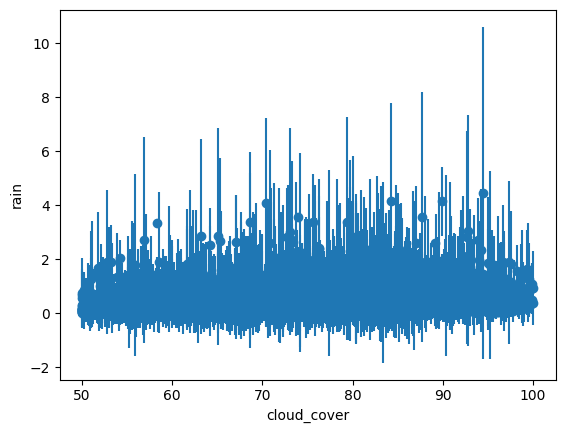

In [0]:
cloud_rain = bkk.groupBy('cloud_cover').agg(mean('precipitation').alias('avg_precipitation'), stddev('precipitation').alias('std_precipitation'), mean("temperature").alias("avg_temperature"), stddev('temperature').alias('std_temperature'), mean("wind_speed").alias("wind_speed"), stddev("wind_speed").alias("wind_speed_std"), mean("rain").alias("rain"), stddev("rain").alias("rain_std")).filter(col('cloud_cover')>=50).sort("cloud_cover", ascending=False).dropna()

xs = [val.cloud_cover for val in cloud_rain.select('cloud_cover').collect()]
ys = [val.rain for val in cloud_rain.select('rain').collect()]
e = [val.rain_std for val in cloud_rain.select('rain_std').collect()]


plt.errorbar(xs, ys, e, linestyle='None', fmt='-o')
plt.xlabel('cloud_cover')
plt.ylabel('rain')

plt.show()

In [0]:
Prob_rain_if_cloud = (cloud_rain.filter(col('rain')>=0.5).count()/bkk.count())/(cloud_rain.count()/bkk.count())

print("prob of moderate rain if a lot of cloud is: "+str(Prob_rain_if_cloud))

prob of moderate rain if a lot of cloud is: 0.21754343629343628


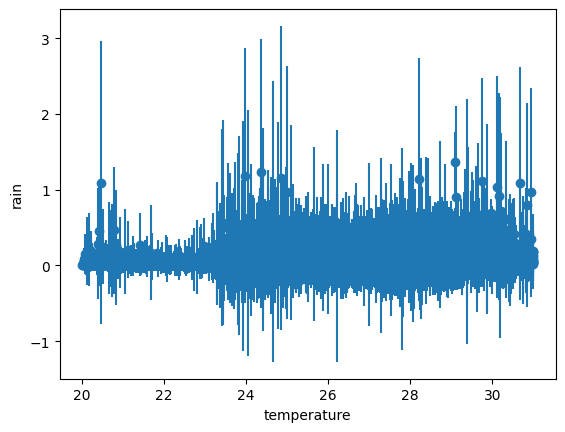

In [0]:
temp_rain = bkk.groupBy('temperature').agg(mean('precipitation').alias('avg_precipitation'), stddev('precipitation').alias('std_precipitation'), mean("cloud_cover").alias("cloud_cover"), stddev('cloud_cover').alias('std_cloud_cover'), mean("wind_speed").alias("wind_speed"), stddev("wind_speed").alias("wind_speed_std"), mean("rain").alias("rain"), stddev("rain").alias("rain_std")).filter((col('temperature') >= 20) & (col('temperature') < 31)).sort("temperature", ascending=False).dropna()

xs = [val.temperature for val in temp_rain.select('temperature').collect()]
ys = [val.rain for val in temp_rain.select('rain').collect()]
e = [val.rain_std for val in temp_rain.select('rain_std').collect()]


plt.errorbar(xs, ys, e, linestyle='None', fmt='-o')
plt.xlabel('temperature')
plt.ylabel('rain')

plt.show()

In [0]:
Prob_rain_if_temp = (temp_rain.filter(col('rain')>=0.3).count())/(temp_rain.count())

print("prob of light rain if medium temp is: "+str(Prob_rain_if_temp))

prob of light rain if medium temp is: 0.03663691874119305


/home/spark-a0fac54b-dccf-453d-8740-b3/.ipykernel/2010/command-2179487235594906-624413574:8: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-o" (-> linestyle='-'). The keyword argument will take precedence.
  plt.errorbar(xs, ys, e, linestyle='None', fmt='-o')


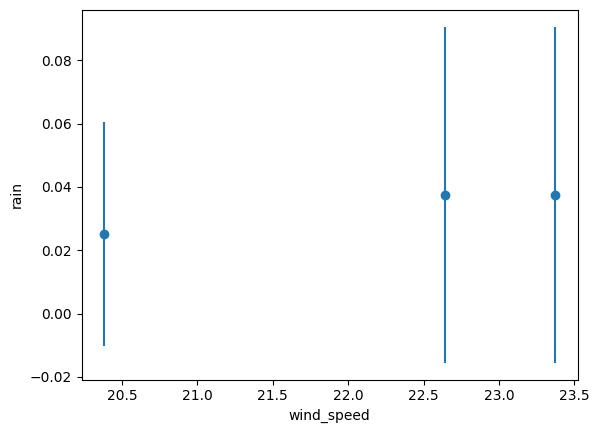

In [0]:
wind_rain = bkk.groupBy('wind_speed').agg(mean('precipitation').alias('avg_precipitation'), stddev('precipitation').alias('std_precipitation'), mean("cloud_cover").alias("cloud_cover"), stddev('cloud_cover').alias('std_cloud_cover'), mean("temperature").alias("temperature"), stddev("temperature").alias("temp_std"), mean("rain").alias("rain"), stddev("rain").alias("rain_std")).filter((col('wind_speed') >= 20) & (col('wind_speed') <= 60)).sort("wind_speed", ascending=False).dropna()

xs = [val.wind_speed for val in wind_rain.select('wind_speed').collect()]
ys = [val.rain for val in wind_rain.select('rain').collect()]
e = [val.rain_std for val in wind_rain.select('rain_std').collect()]


plt.errorbar(xs, ys, e, linestyle='None', fmt='-o')
plt.xlabel('wind_speed')
plt.ylabel('rain')

plt.show()

In [0]:
Prob_rain_if_wind = (wind_rain.filter(col('rain')>=2).count())/(wind_rain.count())

print("prob of moderate rain if temperate wind is: "+str(Prob_rain_if_wind))

prob of moderate rain if temperate wind is: 0.0


In [0]:
group_rain = bkk.groupBy('rain').agg(mean('precipitation').alias('avg_precipitation'), stddev('precipitation').alias('std_precipitation'), mean("cloud_cover").alias("cloud_cover"), stddev('cloud_cover').alias('std_cloud_cover'), mean("temperature").alias("temperature"), stddev("temperature").alias("temp_std"), mean("wind_speed").alias("wind_speed"), stddev("wind_speed").alias("wind_speed_std")).filter((col('wind_speed') >= 20) & (col('wind_speed') <= 60)).sort("wind_speed", ascending=False).dropna()

/home/spark-a0fac54b-dccf-453d-8740-b3/.ipykernel/2010/command-2179487235594920-4012895069:9: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-o" (-> linestyle='-'). The keyword argument will take precedence.
  plt.errorbar(xs, ys, e, linestyle='None', fmt='-o')


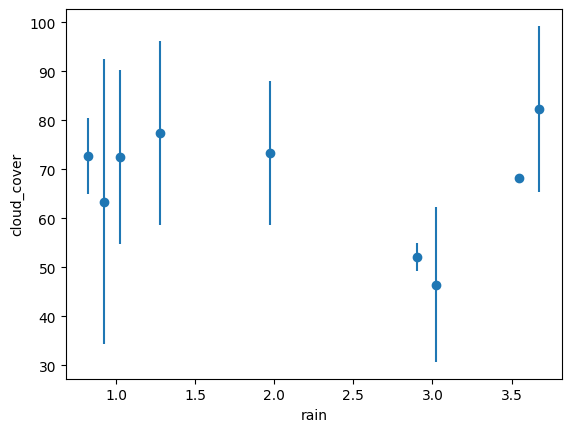

In [0]:
data = group_rain.select('rain', 'cloud_cover', 'std_cloud_cover').collect()

# Extracting values
xs = [val.rain for val in data]
ys = [val.cloud_cover for val in data]
e = [val.std_cloud_cover for val in data]


plt.errorbar(xs, ys, e, linestyle='None', fmt='-o')
plt.xlabel('rain')
plt.ylabel('cloud_cover')

plt.show()

/home/spark-a0fac54b-dccf-453d-8740-b3/.ipykernel/2010/command-2179487235594928-953711020:9: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-o" (-> linestyle='-'). The keyword argument will take precedence.
  plt.errorbar(xs, ys, e, linestyle='None', fmt='-o')


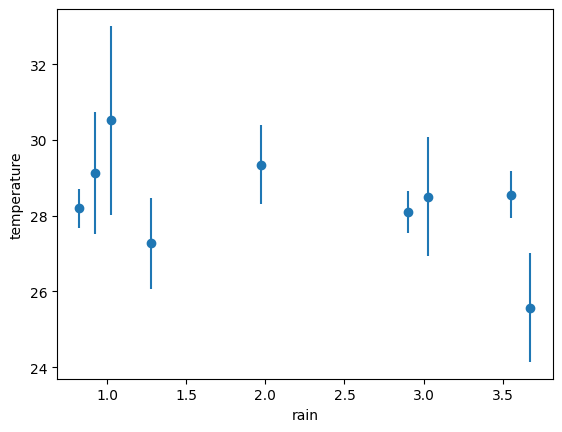

In [0]:
data = group_rain.select('rain', 'temperature', 'temp_std').collect()

# Extracting values
xs = [val.rain for val in data]
ys = [val.temperature for val in data]
e = [val.temp_std for val in data]


plt.errorbar(xs, ys, e, linestyle='None', fmt='-o')
plt.xlabel('rain')
plt.ylabel('temperature')

plt.show()

/home/spark-a0fac54b-dccf-453d-8740-b3/.ipykernel/2010/command-2179487235594921-387313923:6: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-o" (-> linestyle='-'). The keyword argument will take precedence.
  plt.errorbar(xs, ys, e, linestyle='None', fmt='-o')


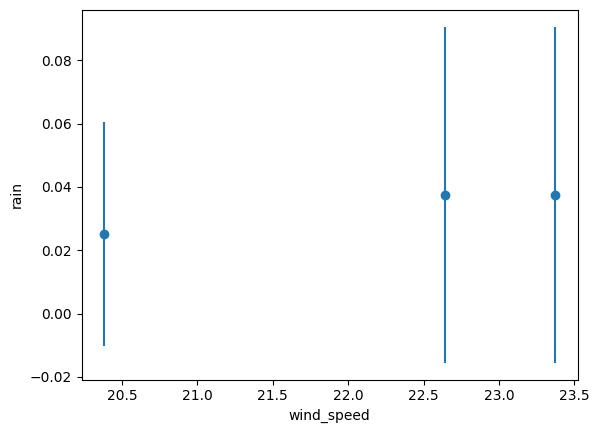

In [0]:
xs = [val.wind_speed for val in wind_rain.select('wind_speed').collect()]
ys = [val.rain for val in wind_rain.select('rain').collect()]
e = [val.rain_std for val in wind_rain.select('rain_std').collect()]


plt.errorbar(xs, ys, e, linestyle='None', fmt='-o')
plt.xlabel('wind_speed')
plt.ylabel('rain')

plt.show()

/home/spark-a0fac54b-dccf-453d-8740-b3/.ipykernel/2010/command-2179487235594922-387313923:6: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-o" (-> linestyle='-'). The keyword argument will take precedence.
  plt.errorbar(xs, ys, e, linestyle='None', fmt='-o')


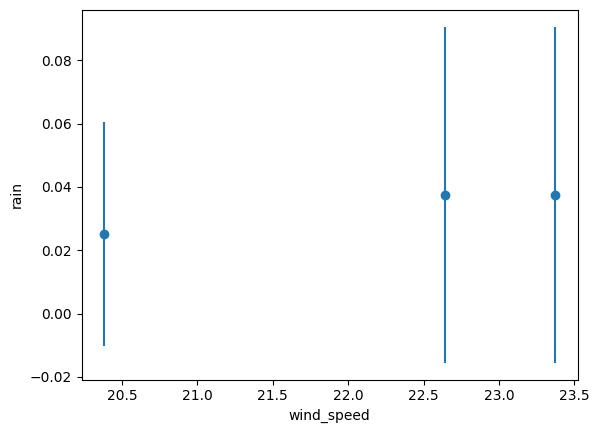

In [0]:
xs = [val.wind_speed for val in wind_rain.select('wind_speed').collect()]
ys = [val.rain for val in wind_rain.select('rain').collect()]
e = [val.rain_std for val in wind_rain.select('rain_std').collect()]


plt.errorbar(xs, ys, e, linestyle='None', fmt='-o')
plt.xlabel('wind_speed')
plt.ylabel('rain')

plt.show()

In [0]:
#trying to find contiguous rain ie periods with a lot of rains or periods before that that it is dry

def contig_rainfall(df):
    rain = df.select('precipitation').toPandas().values
    r = 0
    if rain[0]>=0.5:
        r = 1
    block = (1,r)
    contig_rain = [block]
    for i in range(1, len(rain)):
        if (rain[i] >= 0.5 and contig_rain[-1][1] == 0) or (rain[i] < 2 and contig_rain[-1][1] == 1):
            if block[1]==0:
                r = 1
            else:
                r = 0
            block = (block[0]+1, r)
        if rain[i] < 0.5 and abs(rain[i] - rain[i-1]) > 0.2:
            block = (block[0]+1, 0)
        contig_rain.append(block)
    return contig_rain


contig_rain = contig_rainfall(bkk)

In [0]:
def dupes(lst):
    dct = {}
    for l in lst:
        if l not in dct:
            dct[l] = 1
        else:
            dct[l] = dct[l] + 1
    return dct


rain_freq = dupes(contig_rain)
contigRain = list(map(lambda x: x[0] if isinstance(x, tuple) else x, contig_rain))
rain_period = list(map(lambda x: rain_freq[x], contig_rain))

In [0]:
temp = bkk.toPandas()
temp['rain_group'] = contigRain
temp['rain_period'] = rain_period
bkk_rain = spark.createDataFrame(temp)


In [0]:
grouped_contig = bkk_rain.groupBy('rain_group').agg(mean('precipitation').alias('avg_precipitation'), stddev('precipitation').alias('std_precipitation'),mean("temperature").alias("avg_temperature"),stddev('temperature').alias('std_temperature'), mean("wind_speed").alias("wind_speed"), stddev("wind_speed").alias("wind_speed_std"), mean("rain_period").alias('rain_period'), mean("cloud_cover").alias("cloud_cover"), stddev("cloud_cover").alias("cloud_cover_std"), mean("humidity").alias("humidity"), stddev("humidity").alias("humidity_std"))

In [0]:
only_rain = grouped_contig.filter(col('avg_precipitation') >= 0.5).sort("rain_period", ascending=False)

In [0]:
only_rain_group = only_rain.select(col('rain_group')).collect()
rain_group = [val.rain_group for val in only_rain_group]
rain_group = list(map(lambda x: x-1, rain_group))
rain_group = set(rain_group)

In [0]:
pre_rain = grouped_contig.where(grouped_contig.rain_group.isin(rain_group))

In [0]:


def norm(x, a, b):
    return (1/a)*np.exp(-((x-b)/a)**2)

def cubic(x, a, b, c, d):
    return a*np.power(x,3) + b*np.power(x,2) + c*x + d

def linear(x, a, b):
    return a*x + b

def quadratic(x, a, b, c):
    return a*np.power(x,2) + b*x + c

def mx_filter(ls_tup, nois):
    mx = (0,0)
    for tup in ls_tup:
        if tup[1] > mx[1] and tup[1]-mx[1]<=nois:
            mx = tup
    return mx

def max_slice(ls_tup, start, stop, sl, nois):
    slices = int((stop-start)/sl)
    intervals = np.linspace(start, stop, slices)
    ret = []
    peaks = []
    for i in range(len(intervals)-1):
        temp = []
        for j in range(len(ls_tup)):
            if ls_tup[j][0] >= intervals[i] and ls_tup[j][0] < intervals[i+1]:
                temp.append(ls_tup[j])
        ret.append(temp)
    for r in ret:
        mx = mx_filter(r, nois)
        peaks.append(mx)
    return peaks

def diff(f,x,u):
    return (f(x+u)-f(x-u))/(2*u)

def rem_0(tup):
    if tup == (0,0):
        return False
    else:
        return True


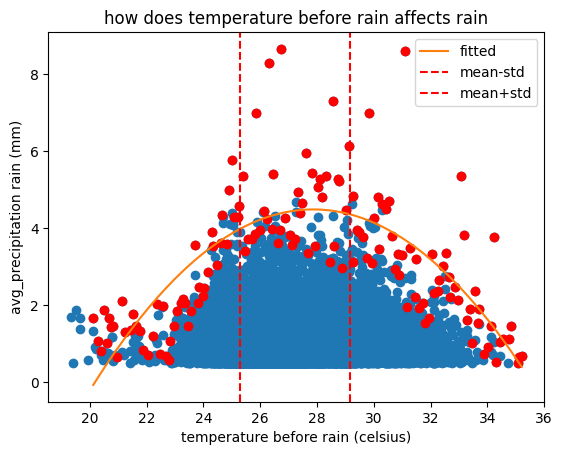

In [0]:
xs = [val.avg_temperature for val in pre_rain.select('avg_temperature').collect()]
ys = [val.avg_precipitation for val in only_rain.select('avg_precipitation').collect()]
zip_xy = list(zip(xs,ys))
zip_xy.sort(key=lambda tup: tup[0])

filtered = list(filter(rem_0,max_slice(zip_xy, 20, 36, 0.1, 6)))

filtered_x = []
filtered_y = []
 
for i in filtered:
    filtered_x.append(i[0])
    filtered_y.append(i[1])

filtered_x = np.array(filtered_x)
filtered_y = np.array(filtered_y)

plt.plot(xs, ys, 'o')
plt.plot(filtered_x, filtered_y, 'o', c='r')
plt.xlabel('temperature before rain (celsius)')
plt.ylabel('avg_precipitation rain (mm)')
popt, pcov = curve_fit(quadratic, filtered_x, filtered_y)

y_fit = quadratic(filtered_x, *popt)
plt.plot(filtered_x, y_fit, label = 'fitted')
plt.title('how does temperature before rain affects rain')
mean_x = np.mean(xs)
std_x = np.std(xs)
plt.axvline(mean_x-std_x, c='r', linestyle='--', label = 'mean-std')
plt.axvline(mean_x+std_x, c='r', linestyle='--', label = 'mean+std')
plt.legend()

In [0]:
xs = [val.avg_temperature for val in pre_rain.select('avg_temperature').collect()]
ys = [val.avg_precipitation for val in only_rain.select('avg_precipitation').collect()]
r = np.corrcoef(xs, ys)
r

array([[1.        , 0.01036176],
       [0.01036176, 1.        ]])

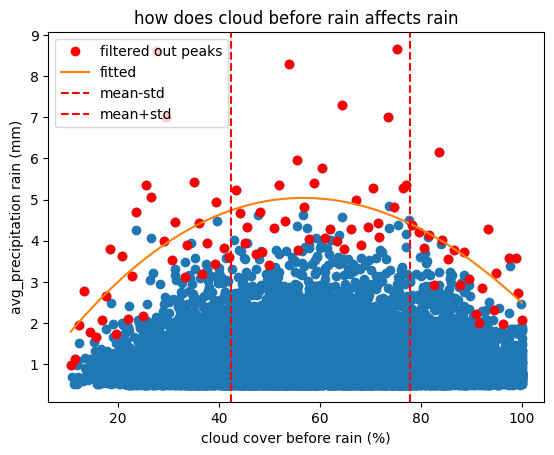

In [0]:
xs = [val.cloud_cover for val in pre_rain.select('cloud_cover').collect()]
ys = [val.avg_precipitation for val in only_rain.select('avg_precipitation').collect()]

plt.plot(xs, ys, 'o')
plt.xlabel('cloud cover before rain (%)')
plt.ylabel('avg_precipitation rain (mm)')

zip_xy = list(zip(xs,ys))
zip_xy.sort(key=lambda tup: tup[0])

filtered = list(filter(rem_0,max_slice(zip_xy, 0, 101, 1, 8)))

filtered_x = []
filtered_y = []
 
for i in filtered:
    filtered_x.append(i[0])
    filtered_y.append(i[1])

filtered_x = np.array(filtered_x)
filtered_y = np.array(filtered_y)

plt.plot(filtered_x, filtered_y, 'o', c='r', label = 'filtered out peaks')
popt, pcov = curve_fit(cubic, filtered_x, filtered_y)

y_fit = cubic(filtered_x, *popt)
plt.plot(filtered_x, y_fit, label = 'fitted')
plt.title('how does cloud before rain affects rain')
mean_x = np.mean(xs)
std_x = np.std(xs)
plt.axvline(mean_x-std_x, c='r', linestyle='--', label = 'mean-std')
plt.axvline(mean_x+std_x, c='r', linestyle='--', label = 'mean+std')
plt.legend()

In [0]:
def sum_sq(y, y_fit):
    return np.sum((y - y_fit) ** 2)

PearsonRResult(statistic=0.00863407762126331, pvalue=0.2805322796569435)

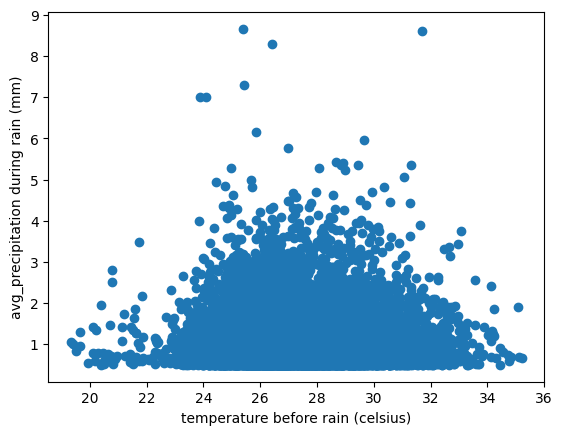

In [0]:
xs = [val.avg_temperature for val in pre_rain.select('avg_temperature').collect()]
ys = [val.avg_precipitation for val in only_rain.select('avg_precipitation').collect()]

plt.scatter(xs, ys)
plt.xlabel('temperature before rain (celsius)')
plt.ylabel('avg_precipitation during rain (mm)')
stats.pearsonr(xs, ys)


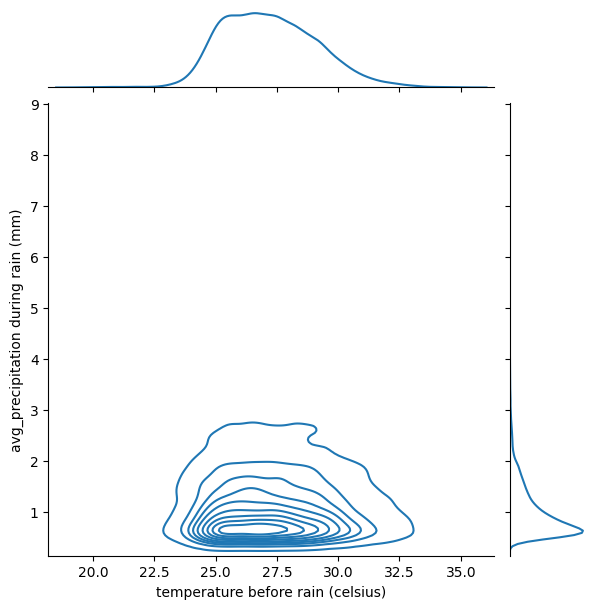

PearsonRResult(statistic=0.0019248958614788733, pvalue=0.8098825478496333)

In [0]:
xs = [val.avg_temperature for val in pre_rain.select('avg_temperature').collect()]
ys = [val.avg_precipitation for val in only_rain.select('avg_precipitation').collect()]

sns.jointplot(x = xs, y = ys, 
              kind = "kde")  
plt.xlabel('temperature before rain (celsius)')
plt.ylabel('avg_precipitation during rain (mm)')
plt.show()
stats.pearsonr(xs, ys)

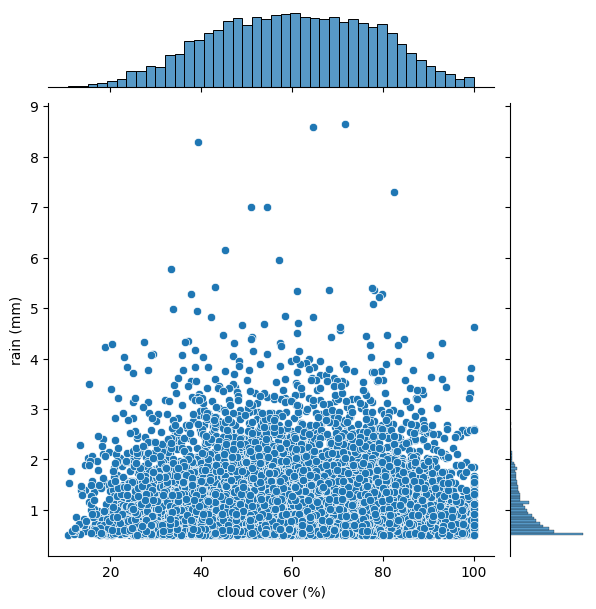

[[ 1.         -0.00738699]
 [-0.00738699  1.        ]]


In [0]:
xs = [val.cloud_cover for val in pre_rain.select('cloud_cover').collect()]
ys = [val.avg_precipitation for val in only_rain.select('avg_precipitation').collect()]

sns.jointplot(x=xs, y=ys, kind='scatter')

plt.xlabel("cloud cover (%)")
plt.ylabel("rain (mm)")

plt.show()
r = np.corrcoef(xs, ys)
print(r)

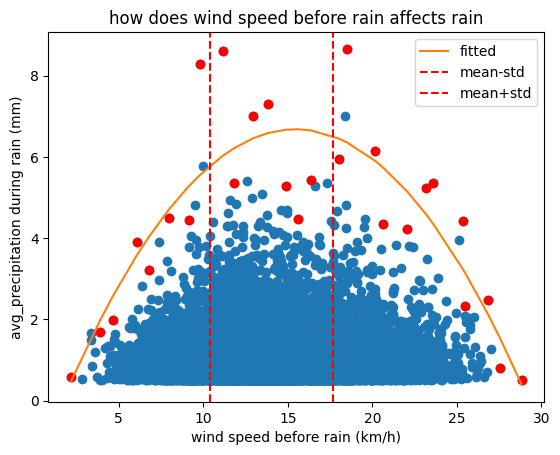

In [0]:
xs = [val.wind_speed for val in pre_rain.select('wind_speed').collect()]
ys = [val.avg_precipitation for val in only_rain.select('avg_precipitation').collect()]

plt.plot(xs, ys, 'o')
plt.xlabel('wind speed before rain (km/h)')
plt.ylabel('avg_precipitation during rain (mm)')

zip_xy = list(zip(xs,ys))
zip_xy.sort(key=lambda tup: tup[0])


def rem_0(tup):
    if tup == (0,0):
        return False
    else:
        return True

filtered = list(filter(rem_0,max_slice(zip_xy, 0, 60, 1, 6)))

filtered_x = []
filtered_y = []
 
for i in filtered:
    filtered_x.append(i[0])
    filtered_y.append(i[1])

filtered_x = np.array(filtered_x)
filtered_y = np.array(filtered_y)

plt.plot(filtered_x, filtered_y, 'o', c='r')
popt, pcov = curve_fit(quadratic, filtered_x, filtered_y)

y_fit = quadratic(filtered_x, *popt)
plt.plot(filtered_x, y_fit, label = 'fitted')

plt.title('how does wind speed before rain affects rain')
mean_x = np.mean(xs)
std_x = np.std(xs)
plt.axvline(mean_x-std_x, c='r', linestyle='--', label = 'mean-std')
plt.axvline(mean_x+std_x, c='r', linestyle='--', label = 'mean+std')
plt.legend()

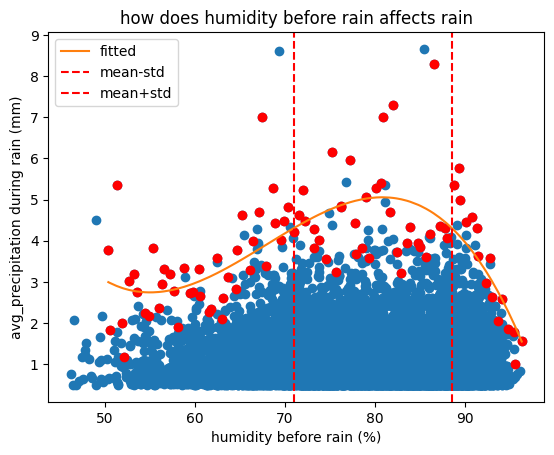

In [0]:
xs = [val.humidity for val in pre_rain.select('humidity').collect()]
ys = [val.avg_precipitation for val in only_rain.select('avg_precipitation').collect()]

plt.plot(xs, ys, 'o')
plt.xlabel('humidity before rain (%)')
plt.ylabel('avg_precipitation during rain (mm)')

zip_xy = list(zip(xs,ys))
zip_xy.sort(key=lambda tup: tup[0])


def rem_0(tup):
    if tup == (0,0):
        return False
    else:
        return True

filtered = list(filter(rem_0,max_slice(zip_xy, 50, 100, 0.5, 6)))

filtered_x = []
filtered_y = []
 
for i in filtered:
    filtered_x.append(i[0])
    filtered_y.append(i[1])

filtered_x = np.array(filtered_x)
filtered_y = np.array(filtered_y)

plt.plot(filtered_x, filtered_y, 'o', c='r')
popt, pcov = curve_fit(cubic, filtered_x, filtered_y)

y_fit = cubic(filtered_x, *popt)
plt.plot(filtered_x, y_fit, label = 'fitted')

plt.title('how does humidity before rain affects rain')
mean_x = np.mean(xs)
std_x = np.std(xs)
plt.axvline(mean_x-std_x, c='r', linestyle='--', label = 'mean-std')
plt.axvline(mean_x+std_x, c='r', linestyle='--', label = 'mean+std')
plt.legend()

In [0]:
xs = [val.humidity for val in pre_rain.select('humidity').collect()]
ys = [val.avg_precipitation for val in only_rain.select('avg_precipitation').collect()]

Text(0.5, 1.0, 'how does rain amount affects how long it rains')

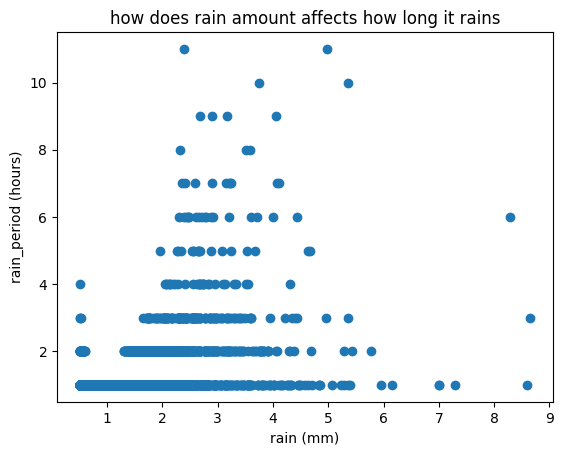

In [0]:
xs = [val.avg_precipitation for val in only_rain.select('avg_precipitation').collect()]
ys = [val.rain_period for val in only_rain.select('rain_period').collect()]

plt.plot(xs, ys, 'o')
plt.xlabel('rain (mm)')
plt.ylabel('rain_period (hours)')
plt.title('how does rain amount affects how long it rains')

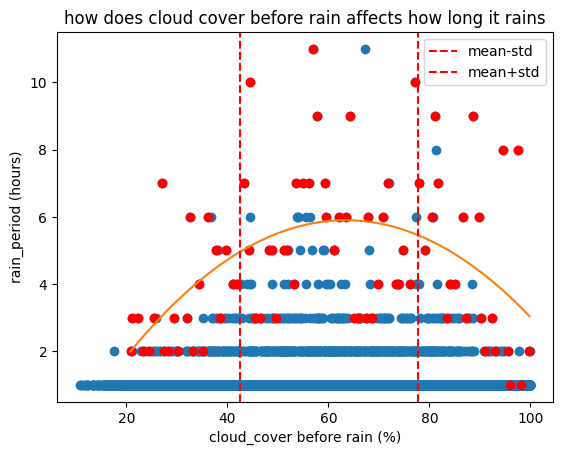

In [0]:
xs = [val.cloud_cover for val in pre_rain.select('cloud_cover').collect()]
ys = [val.rain_period for val in only_rain.select('rain_period').collect()]

plt.plot(xs, ys, 'o')
plt.xlabel('cloud_cover before rain (%)')
plt.ylabel('rain_period (hours)')

zip_xy = list(zip(xs,ys))
zip_xy.sort(key=lambda tup: tup[0])


def rem_0(tup):
    if tup == (0,0):
        return False
    else:
        return True

filtered = list(filter(rem_0,max_slice(zip_xy, 20, 100, 1, 8)))

filtered_x = []
filtered_y = []
 
for i in filtered:
    filtered_x.append(i[0])
    filtered_y.append(i[1])

filtered_x = np.array(filtered_x)
filtered_y = np.array(filtered_y)

plt.plot(filtered_x, filtered_y, 'o', c='r')
popt, pcov = curve_fit(quadratic, filtered_x, filtered_y)

y_fit = quadratic(filtered_x, *popt)
plt.plot(filtered_x, y_fit)
plt.title('how does cloud cover before rain affects how long it rains')
mean_x = np.mean(xs)
std_x = np.std(xs)
plt.axvline(mean_x-std_x, c='r', linestyle='--', label = 'mean-std')
plt.axvline(mean_x+std_x, c='r', linestyle='--', label = 'mean+std')
plt.legend()

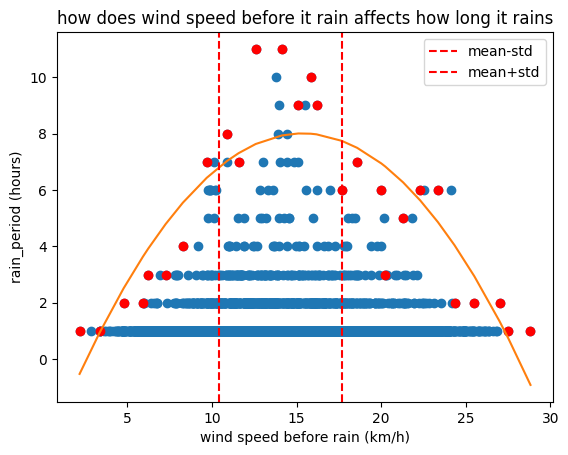

In [0]:
xs = [val.wind_speed for val in pre_rain.select('wind_speed').collect()]
ys = [val.rain_period for val in only_rain.select('rain_period').collect()]

plt.plot(xs, ys, 'o')

zip_xy = list(zip(xs,ys))
zip_xy.sort(key=lambda tup: tup[0])

plt.xlabel('wind speed before rain (km/h)')
plt.ylabel('rain_period (hours)')


def rem_0(tup):
    if tup == (0,0):
        return False
    else:
        return True

filtered = list(filter(rem_0,max_slice(zip_xy, 0, 100, 1, 8)))

filtered_x = []
filtered_y = []
 
for i in filtered:
    filtered_x.append(i[0])
    filtered_y.append(i[1])

filtered_x = np.array(filtered_x)
filtered_y = np.array(filtered_y)

plt.plot(filtered_x, filtered_y, 'o', c='r')
popt, pcov = curve_fit(quadratic, filtered_x, filtered_y)

y_fit = quadratic(filtered_x, *popt)
plt.plot(filtered_x, y_fit)
plt.title('how does wind speed before it rain affects how long it rains')
mean_x = np.mean(xs)
std_x = np.std(xs)
plt.axvline(mean_x-std_x, c='r', linestyle='--', label = 'mean-std')
plt.axvline(mean_x+std_x, c='r', linestyle='--', label = 'mean+std')
plt.legend()

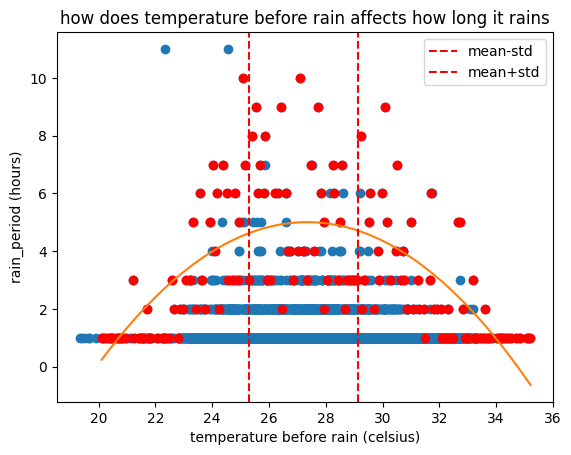

In [0]:
xs = [val.avg_temperature for val in pre_rain.select('avg_temperature').collect()]
ys = [val.rain_period for val in only_rain.select('rain_period').collect()]

plt.plot(xs, ys, 'o')

zip_xy = list(zip(xs,ys))
zip_xy.sort(key=lambda tup: tup[0])

plt.xlabel('temperature before rain (celsius)')
plt.ylabel('rain_period (hours)')


def rem_0(tup):
    if tup == (0,0):
        return False
    else:
        return True

filtered = list(filter(rem_0,max_slice(zip_xy, 20, 36, 0.1, 8)))

filtered_x = []
filtered_y = []
 
for i in filtered:
    filtered_x.append(i[0])
    filtered_y.append(i[1])

filtered_x = np.array(filtered_x)
filtered_y = np.array(filtered_y)

plt.plot(filtered_x, filtered_y, 'o', c='r')
popt, pcov = curve_fit(quadratic, filtered_x, filtered_y)

y_fit = quadratic(filtered_x, *popt)
plt.plot(filtered_x, y_fit)
plt.title('how does temperature before rain affects how long it rains')
mean_x = np.mean(xs)
std_x = np.std(xs)
plt.axvline(mean_x-std_x, c='r', linestyle='--', label = 'mean-std')
plt.axvline(mean_x+std_x, c='r', linestyle='--', label = 'mean+std')
plt.legend()

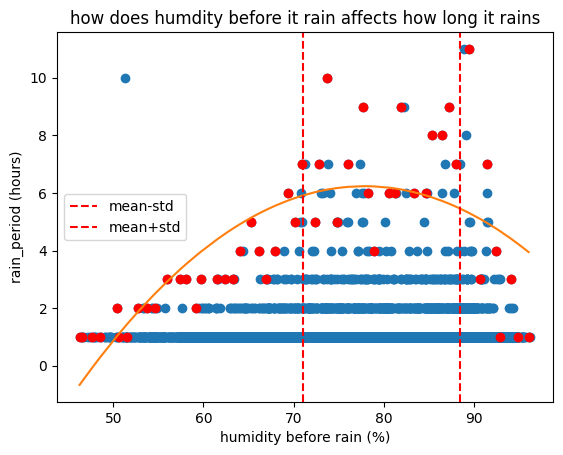

In [0]:
xs = [val.humidity for val in pre_rain.select('humidity').collect()]
ys = [val.rain_period for val in only_rain.select('rain_period').collect()]

plt.plot(xs, ys, 'o')

zip_xy = list(zip(xs,ys))
zip_xy.sort(key=lambda tup: tup[0])

plt.xlabel('humidity before rain (%)')
plt.ylabel('rain_period (hours)')


def rem_0(tup):
    if tup == (0,0):
        return False
    else:
        return True

filtered = list(filter(rem_0,max_slice(zip_xy, 0, 100, 1, 8)))

filtered_x = []
filtered_y = []
 
for i in filtered:
    filtered_x.append(i[0])
    filtered_y.append(i[1])

filtered_x = np.array(filtered_x)
filtered_y = np.array(filtered_y)

plt.plot(filtered_x, filtered_y, 'o', c='r')
popt, pcov = curve_fit(quadratic, filtered_x, filtered_y)

y_fit = quadratic(filtered_x, *popt)
plt.plot(filtered_x, y_fit)
plt.title('how does humdity before it rain affects how long it rains')
mean_x = np.mean(xs)
std_x = np.std(xs)
plt.axvline(mean_x-std_x, c='r', linestyle='--', label = 'mean-std')
plt.axvline(mean_x+std_x, c='r', linestyle='--', label = 'mean+std')
plt.legend()

In [0]:
def remove_none(tup):
    if tup == None or tup[1]==None or tup[0]==None:
        return False
    else:
        return True

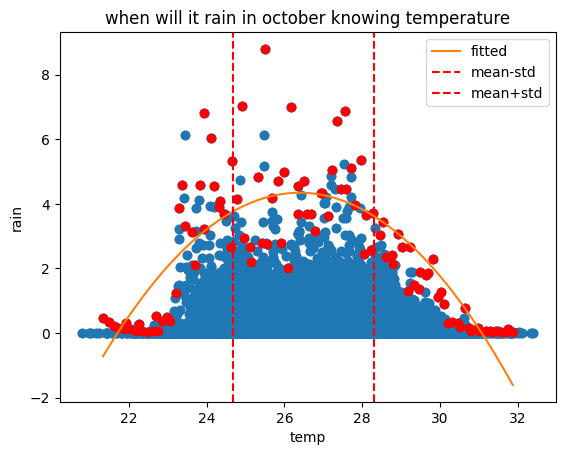

In [0]:
oct_rain = bkk.filter((col('month') == 10))
xs = [val.temperature for val in oct_rain.select('temperature').collect()]
ys = [val.rain for val in oct_rain.select('rain').collect()]
zip_xy = list(filter(remove_none,list(zip(xs,ys))))
xs = []
ys = []
for z in zip_xy:
    xs.append(z[0])
    ys.append(z[1])
zip_xy.sort(key=lambda tup: tup[0])
filtered = list(filter(rem_0,max_slice(zip_xy, 20, 32, 0.1, 6)))
filtered_x = []
filtered_y = []
plt.title('when will it rain in october knowing temperature') 
for i in filtered:
    filtered_x.append(i[0])
    filtered_y.append(i[1])
filtered_x = np.array(filtered_x)
filtered_y = np.array(filtered_y)
plt.plot(xs, ys, 'o')
plt.plot(filtered_x, filtered_y, 'o', c='r')
popt, pcov = curve_fit(quadratic, filtered_x, filtered_y)
y_fit = quadratic(filtered_x, *popt)
plt.plot(filtered_x, y_fit, label='fitted')  
plt.xlabel('temp')
plt.ylabel('rain')
plt.scatter(xs, ys)
mean_x = np.mean(xs)
std_x = np.std(xs)
plt.axvline(mean_x-std_x, c='r', linestyle='--', label = 'mean-std')
plt.axvline(mean_x+std_x, c='r', linestyle='--', label = 'mean+std')
plt.legend()
plt.show()

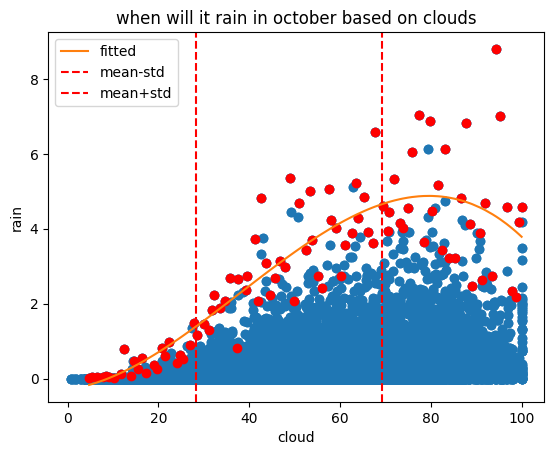

In [0]:
xs = [val.cloud_cover for val in oct_rain.select('cloud_cover').collect()]
ys = [val.rain for val in oct_rain.select('rain').collect()]
zip_xy = list(filter(remove_none,list(zip(xs,ys))))
xs = []
ys = []
for z in zip_xy:
    xs.append(z[0])
    ys.append(z[1])
zip_xy.sort(key=lambda tup: tup[0])
filtered = list(filter(rem_0,max_slice(zip_xy, 0, 101, 1, 8)))
filtered_x = []
filtered_y = []
plt.title('when will it rain in october based on clouds') 
for i in filtered:
    filtered_x.append(i[0])
    filtered_y.append(i[1])
filtered_x = np.array(filtered_x)
filtered_y = np.array(filtered_y)
plt.plot(xs, ys, 'o')
plt.plot(filtered_x, filtered_y, 'o', c='r')
popt, pcov = curve_fit(cubic, filtered_x, filtered_y)
y_fit = cubic(filtered_x, *popt)
plt.plot(filtered_x, y_fit, label='fitted')  
plt.xlabel('cloud')
plt.ylabel('rain')
plt.scatter(xs, ys)
mean_x = np.mean(xs)
std_x = np.std(xs)
plt.axvline(mean_x-std_x, c='r', linestyle='--', label = 'mean-std')
plt.axvline(mean_x+std_x, c='r', linestyle='--', label = 'mean+std')
plt.legend()
plt.show()

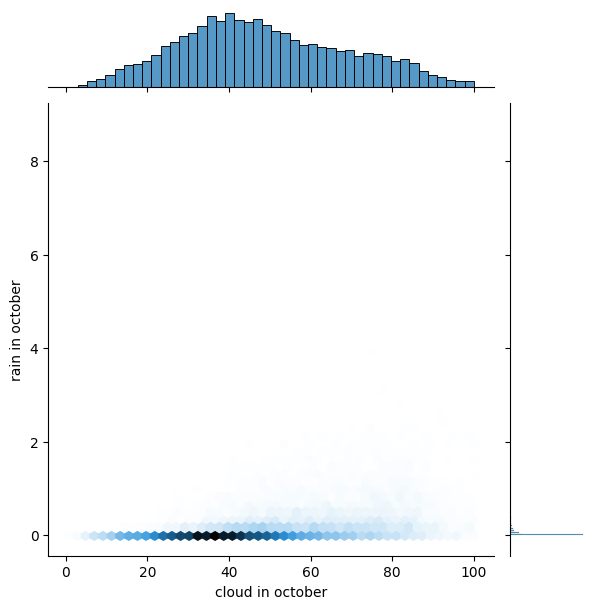

PearsonRResult(statistic=0.3757645619179635, pvalue=0.0)

In [0]:
xs = [val.cloud_cover for val in oct_rain.select('cloud_cover').collect()]
ys = [val.rain for val in oct_rain.select('rain').collect()]

sns.jointplot(x=xs, y=ys, kind='hex')
plt.xlabel('cloud in october')
plt.ylabel('rain in october')
plt.show()
stats.pearsonr(xs, ys)

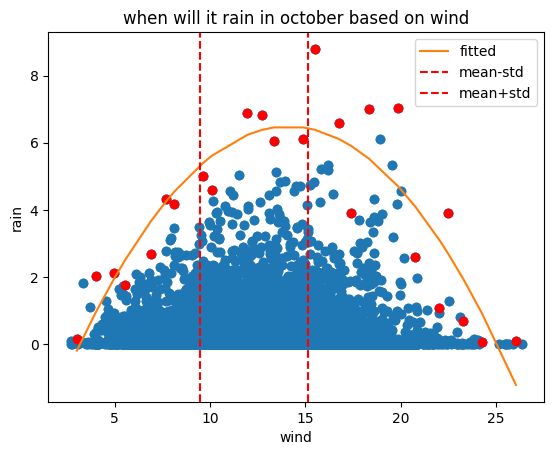

In [0]:
xs = [val.wind_speed for val in oct_rain.select('wind_speed').collect()]
ys = [val.rain for val in oct_rain.select('rain').collect()]
zip_xy = list(filter(remove_none,list(zip(xs,ys))))
xs = []
ys = []
for z in zip_xy:
    xs.append(z[0])
    ys.append(z[1])
zip_xy.sort(key=lambda tup: tup[0])
filtered = list(filter(rem_0,max_slice(zip_xy, 0, 100, 1, 6)))
filtered_x = []
filtered_y = []
plt.title('when will it rain in october based on wind') 
for i in filtered:
    filtered_x.append(i[0])
    filtered_y.append(i[1])
filtered_x = np.array(filtered_x)
filtered_y = np.array(filtered_y)
plt.plot(xs, ys, 'o')
plt.plot(filtered_x, filtered_y, 'o', c='r')
popt, pcov = curve_fit(quadratic, filtered_x, filtered_y)
y_fit = quadratic(filtered_x, *popt)
plt.plot(filtered_x, y_fit, label='fitted')  
plt.xlabel('wind')
plt.ylabel('rain')
plt.scatter(xs, ys)
mean_x = np.mean(xs)
std_x = np.std(xs)
plt.axvline(mean_x-std_x, c='r', linestyle='--', label = 'mean-std')
plt.axvline(mean_x+std_x, c='r', linestyle='--', label = 'mean+std')
plt.legend()
plt.show()

In [0]:
#create new column that rounds values in points column to 2 decimal places
oct_rain = oct_rain.withColumn('temperature', round(oct_rain.temperature, 1))

In [0]:
oct_rain_temp = oct_rain.groupBy('temperature').agg(mean('rain').alias('rain'), stddev('rain').alias('std_rain'))

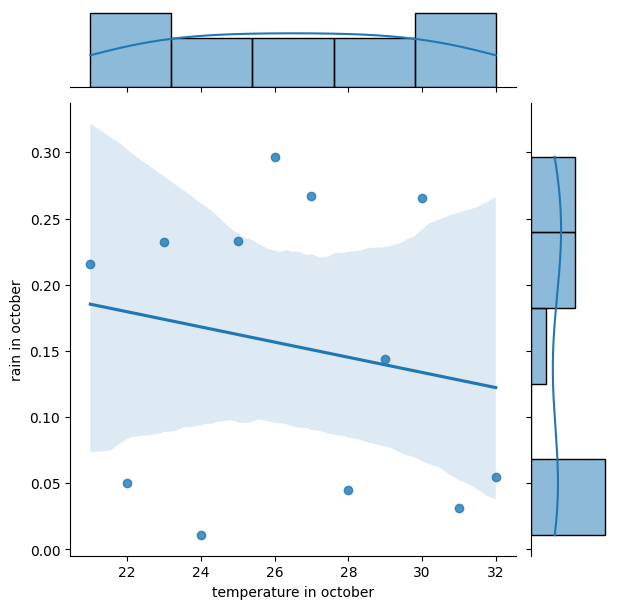

<function scipy.stats._stats_py.pearsonr(x, y, *, alternative='two-sided', method=None)>

In [0]:
xs = [val.temperature for val in oct_rain_temp.select('temperature').collect()]
ys = [val.rain for val in oct_rain_temp.select('rain').collect()]
sns.jointplot(x=xs, y=ys, kind='reg')
plt.xlabel('temperature in october')
plt.ylabel('rain in october')
plt.show()

In [0]:
stats.pearsonr(xs, ys)

PearsonRResult(statistic=-0.1900510300578419, pvalue=0.5541008256515603)

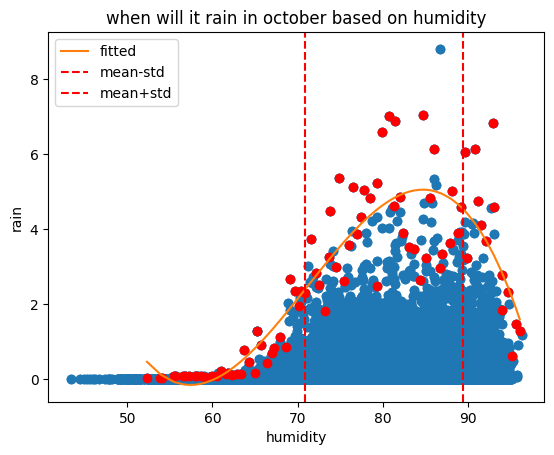

In [0]:
xs = [val.humidity for val in oct_rain.select('humidity').collect()]
ys = [val.precipitation for val in oct_rain.select('precipitation').collect()]
zip_xy = list(filter(remove_none,list(zip(xs,ys))))
xs = []
ys = []
for z in zip_xy:
    xs.append(z[0])
    ys.append(z[1])
zip_xy.sort(key=lambda tup: tup[0])
filtered = list(filter(rem_0,max_slice(zip_xy, 50, 100, 0.5, 6)))
filtered_x = []
filtered_y = []
plt.title('when will it rain in october based on humidity') 
for i in filtered:
    filtered_x.append(i[0])
    filtered_y.append(i[1])
filtered_x = np.array(filtered_x)
filtered_y = np.array(filtered_y)
plt.plot(xs, ys, 'o')
plt.plot(filtered_x, filtered_y, 'o', c='r')
popt, pcov = curve_fit(cubic, filtered_x, filtered_y)
y_fit = cubic(filtered_x, *popt)
plt.plot(filtered_x, y_fit, label='fitted')  
plt.xlabel('humidity')
plt.ylabel('rain')
plt.scatter(xs, ys)
mean_x = np.mean(xs)
std_x = np.std(xs)
plt.axvline(mean_x-std_x, c='r', linestyle='--', label = 'mean-std')
plt.axvline(mean_x+std_x, c='r', linestyle='--', label = 'mean+std')
plt.legend()
plt.show()

In [0]:
oct_rain_bkk = spark.sql("SELECT * FROM bangkok_new").filter(col('month') == '10')

In [0]:
just_bkk = spark.sql("SELECT * FROM bangkok_new")

/home/spark-a0fac54b-dccf-453d-8740-b3/.ipykernel/2010/command-2693603521111387-3777643187:8: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-o" (-> linestyle='-'). The keyword argument will take precedence.
  plt.errorbar(xs, ys, e, linestyle='None', fmt='-o')


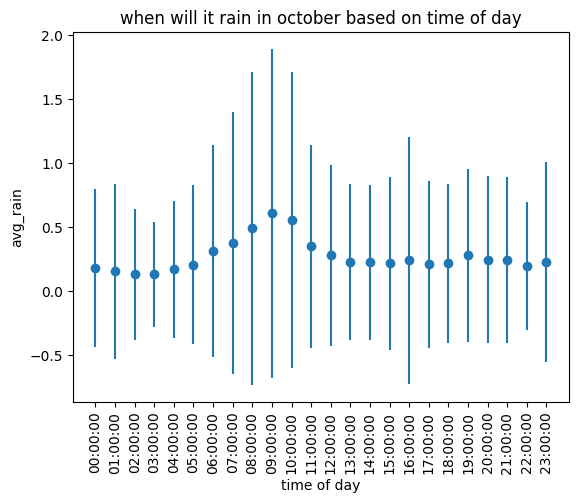

In [0]:
oct_time = oct_rain_bkk.groupBy('time').agg(mean('rain').alias('rain'), stddev('rain').alias('std_rain')).sort("time", ascending=True)
xs = [val.time for val in oct_time.select('time').collect()]
ys = [val.rain for val in oct_time.select('rain').collect()]
plt.title('when will it rain in october based on time of day')
e = [val.std_rain for val in oct_time.select('std_rain').collect()]


plt.errorbar(xs, ys, e, linestyle='None', fmt='-o')
plt.xlabel('time of day')
plt.ylabel('avg_rain')
plt.xticks(rotation=90)

plt.show()


In [0]:
bkk_month = just_bkk.groupBy('month').agg(mean('rain').alias('rain'), stddev('rain').alias('std_rain'),mean("temperature_2m").alias("avg_temperature"),stddev('temperature_2m').alias('std_temperature'), mean("wind_speed_10m").alias("wind_speed"), stddev("wind_speed_10m").alias("wind_speed_std"), mean("cloud_cover").alias("cloud_cover"), stddev("cloud_cover").alias("cloud_cover_std")).sort("month", ascending=True)

/home/spark-a0fac54b-dccf-453d-8740-b3/.ipykernel/2010/command-1088863890951338-629423473:6: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-o" (-> linestyle='-'). The keyword argument will take precedence.
  plt.errorbar(xs, ys, e, linestyle='None', fmt='-o')


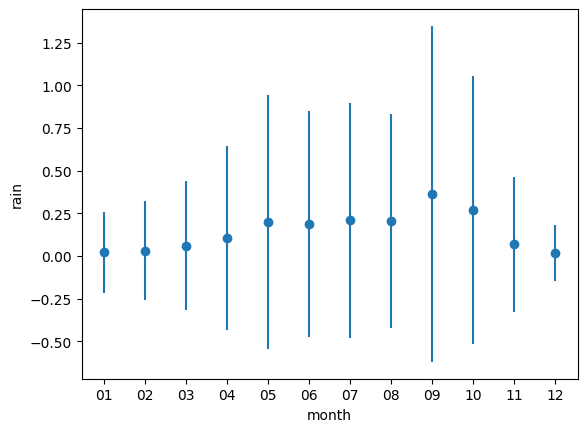

In [0]:
xs = [val.month for val in bkk_month.select('month').collect()]
ys = [val.rain for val in bkk_month.select('rain').collect()]
e = [val.std_rain for val in bkk_month.select('std_rain').collect()]


plt.errorbar(xs, ys, e, linestyle='None', fmt='-o')
plt.xlabel('month')
plt.ylabel('rain')

plt.show()

/home/spark-a0fac54b-dccf-453d-8740-b3/.ipykernel/2010/command-1088863890951353-237592467:6: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-o" (-> linestyle='-'). The keyword argument will take precedence.
  plt.errorbar(xs, ys, e, linestyle='None', fmt='-o')


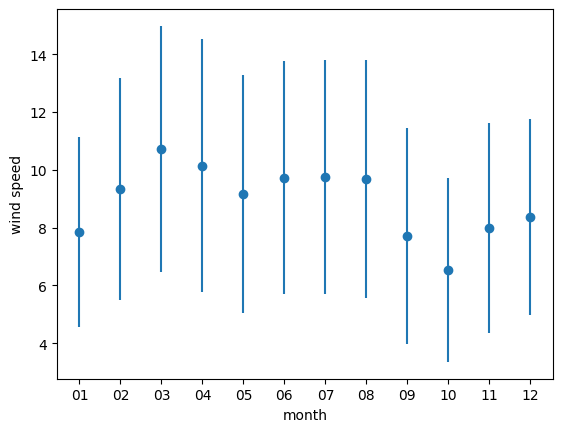

In [0]:
xs = [val.month for val in bkk_month.select('month').collect()]
ys = [val.wind_speed for val in bkk_month.select('wind_speed').collect()]
e = [val.wind_speed_std for val in bkk_month.select('wind_speed_std').collect()]


plt.errorbar(xs, ys, e, linestyle='None', fmt='-o')
plt.xlabel('month')
plt.ylabel('wind speed')

plt.show()

/home/spark-a0fac54b-dccf-453d-8740-b3/.ipykernel/2010/command-1088863890951354-3324653954:5: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-o" (-> linestyle='-'). The keyword argument will take precedence.
  plt.errorbar(xs, ys, e, linestyle='None', fmt='-o')


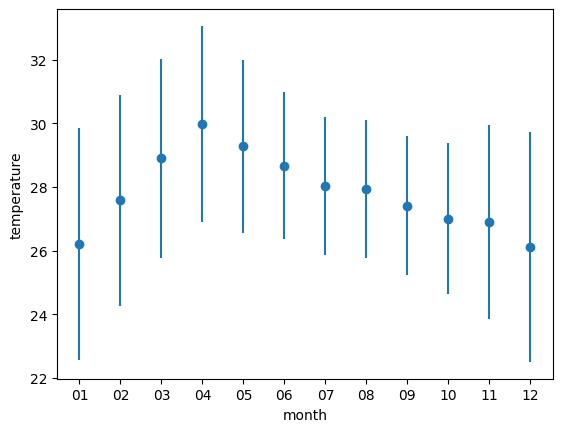

In [0]:
ys = [val.avg_temperature for val in bkk_month.select('avg_temperature').collect()]
e = [val.std_temperature for val in bkk_month.select('std_temperature').collect()]


plt.errorbar(xs, ys, e, linestyle='None', fmt='-o')
plt.xlabel('month')
plt.ylabel('temperature')

plt.show()

/home/spark-a0fac54b-dccf-453d-8740-b3/.ipykernel/2010/command-1088863890951355-230489566:5: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-o" (-> linestyle='-'). The keyword argument will take precedence.
  plt.errorbar(xs, ys, e, linestyle='None', fmt='-o')


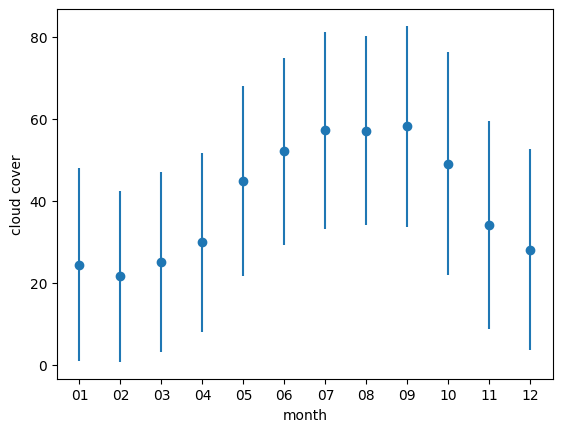

In [0]:
ys = [val.cloud_cover for val in bkk_month.select('cloud_cover').collect()]
e = [val.cloud_cover_std for val in bkk_month.select('cloud_cover_std').collect()]


plt.errorbar(xs, ys, e, linestyle='None', fmt='-o')
plt.xlabel('month')
plt.ylabel('cloud cover')

plt.show()

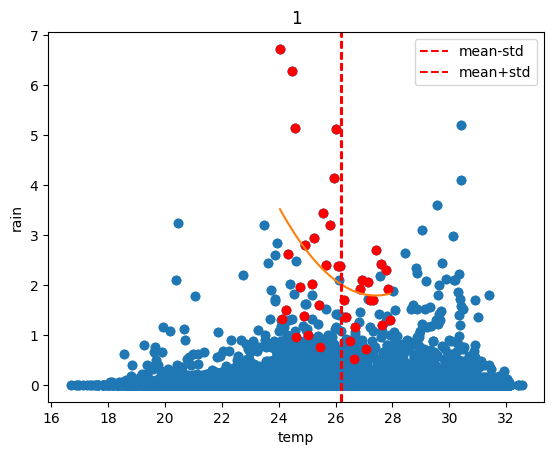

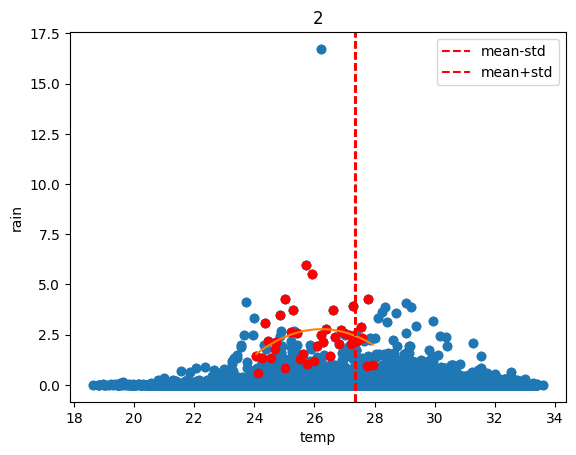

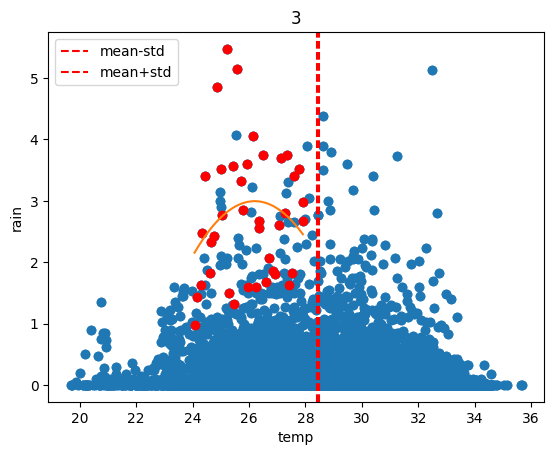

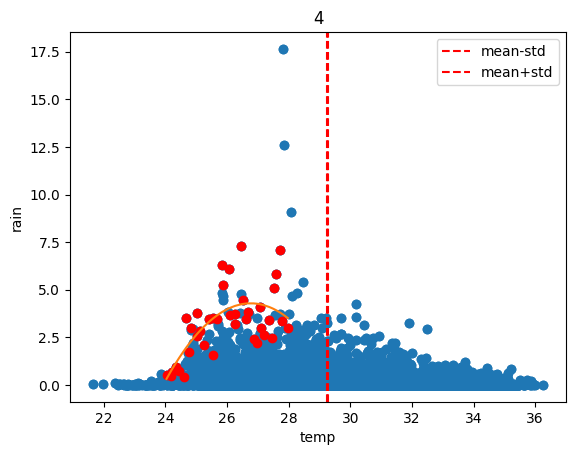

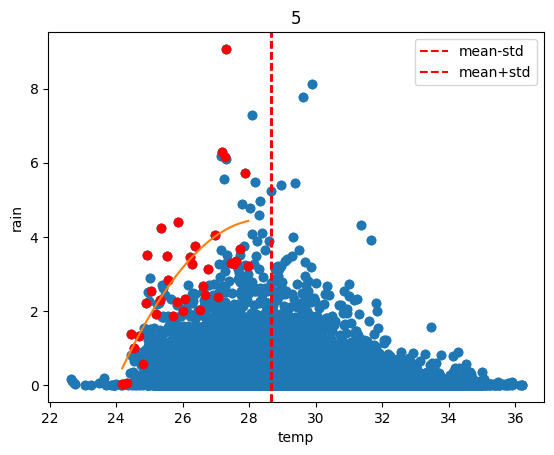

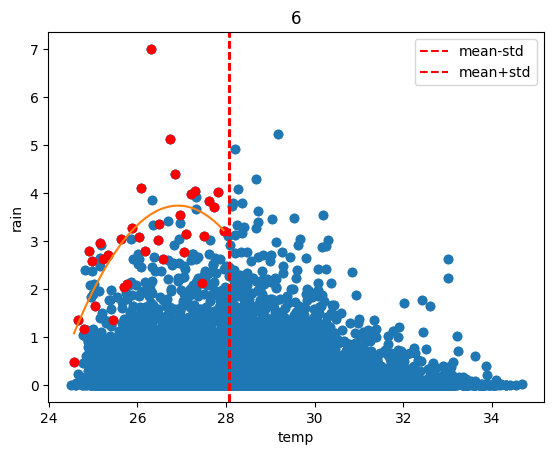

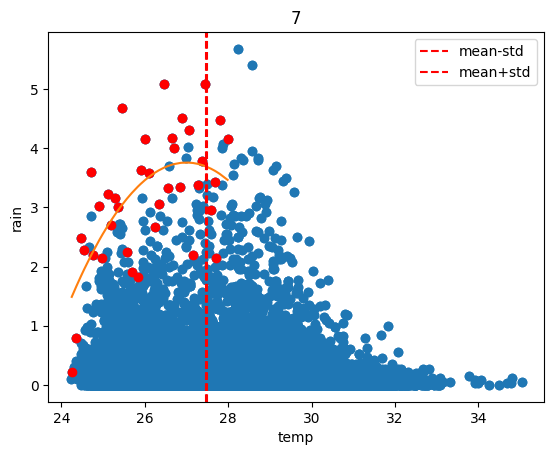

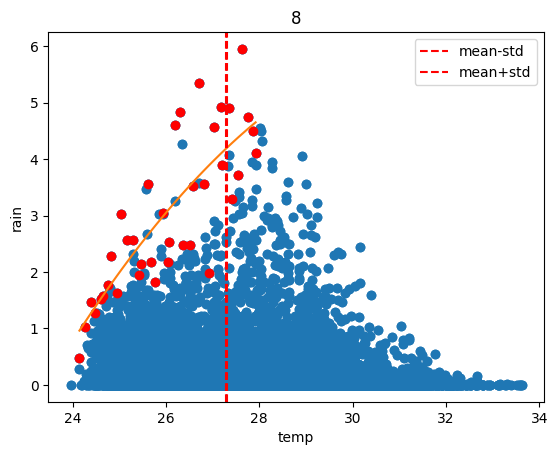

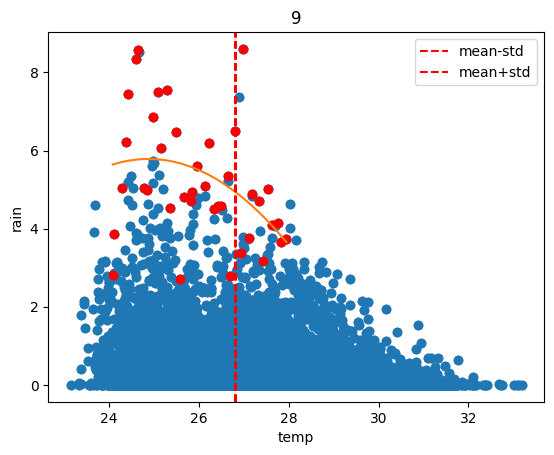

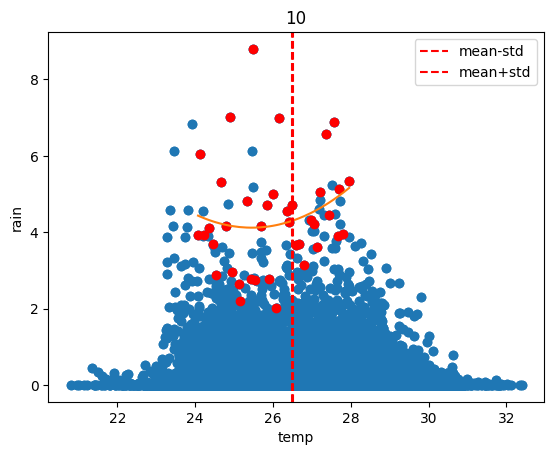

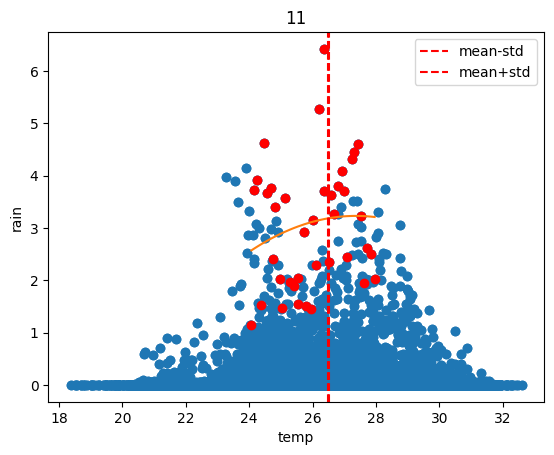

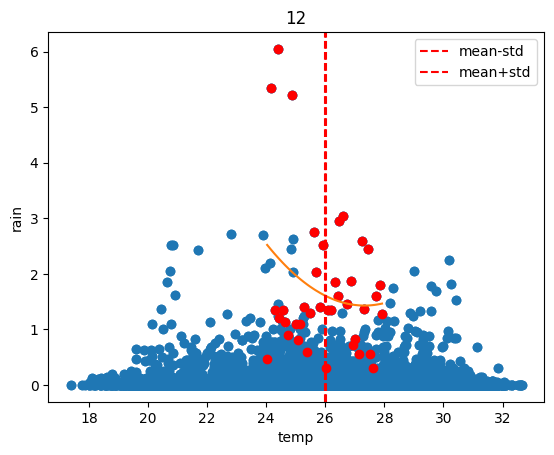

In [0]:
for i in range(1,13):
    month_rain = bkk_rain.filter(col('month') == i)
    xs = [val.temperature for val in month_rain.select('temperature').collect()]
    ys = [val.rain for val in month_rain.select('rain').collect()]
    zip_xy = list(filter(remove_none,list(zip(xs,ys))))

    xs = []
    ys = []

    for z in zip_xy:
        xs.append(z[0])
        ys.append(z[1])


    zip_xy.sort(key=lambda tup: tup[0])
    filtered = list(filter(rem_0,max_slice(zip_xy, 24, 28, 0.1, 6)))
    filtered_x = []
    filtered_y = []
    plt.title(i)
 
    for i in filtered:
        filtered_x.append(i[0])
        filtered_y.append(i[1])
    filtered_x = np.array(filtered_x)
    filtered_y = np.array(filtered_y)
    plt.plot(xs, ys, 'o')
    plt.plot(filtered_x, filtered_y, 'o', c='r')
    popt, pcov = curve_fit(quadratic, filtered_x, filtered_y)
    y_fit = quadratic(filtered_x, *popt)
    plt.plot(filtered_x, y_fit)  
    plt.xlabel('temp')
    plt.ylabel('rain')
    plt.scatter(xs, ys)
    mean_x = np.mean(xs)
    std_x = np.std(xs)
    plt.axvline(mean_x-std_x/np.sqrt(len(xs)), c='r', linestyle='--', label = 'mean-std')
    plt.axvline(mean_x+std_x/np.sqrt(len(xs)), c='r', linestyle='--', label = 'mean+std')
    plt.legend()
    plt.show()


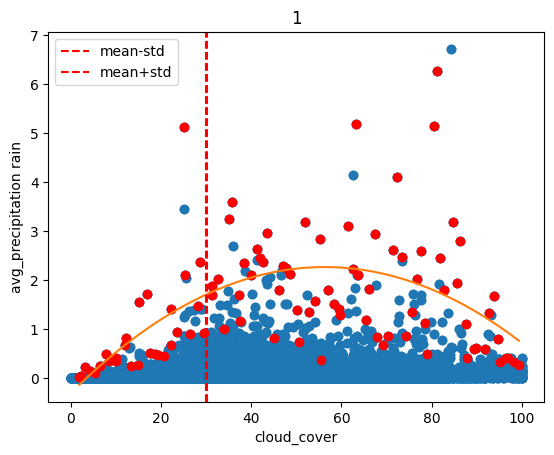

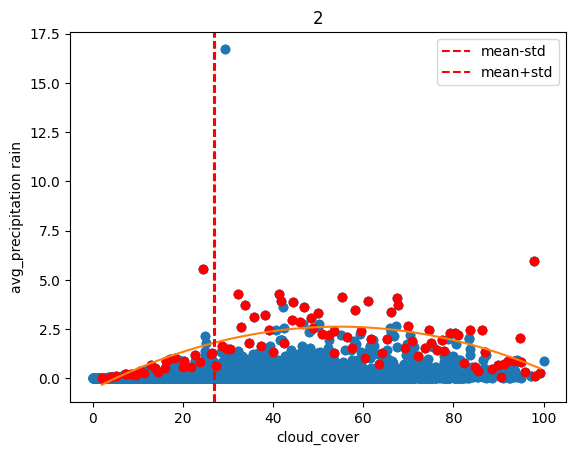

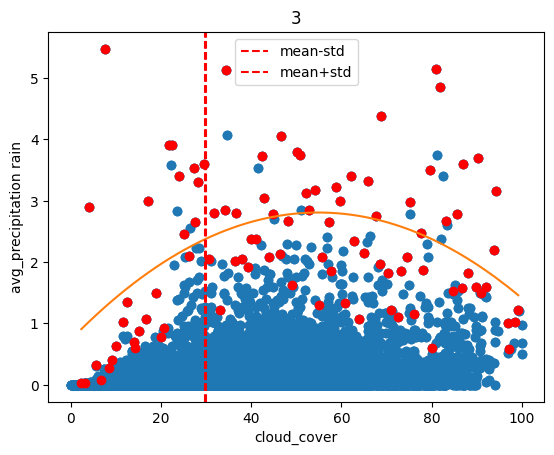

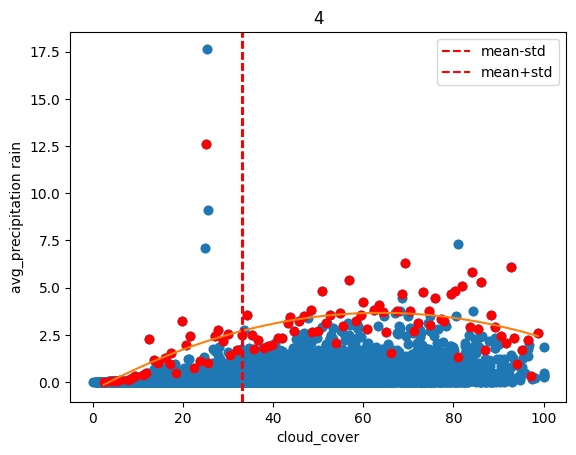

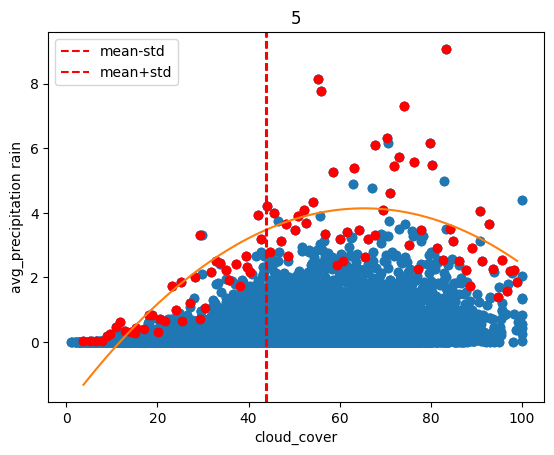

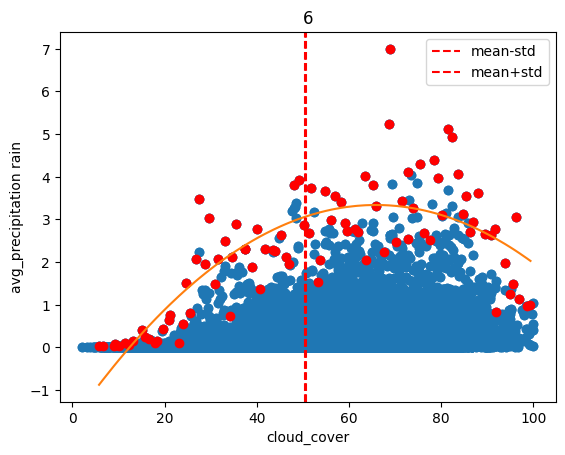

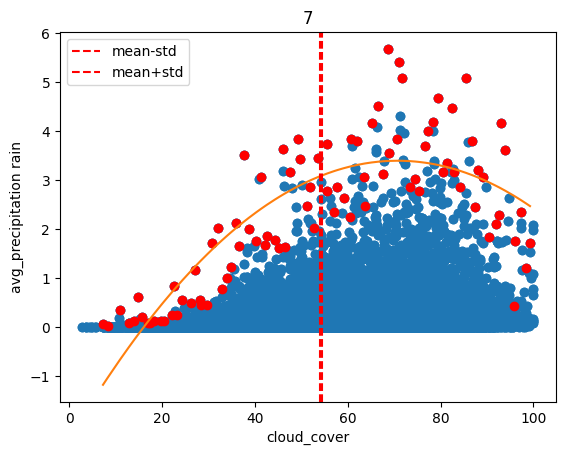

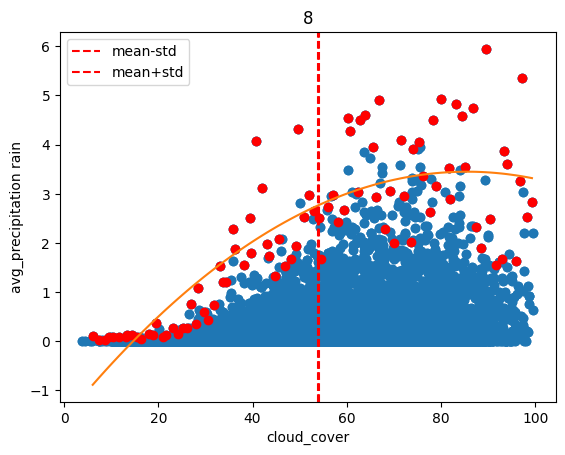

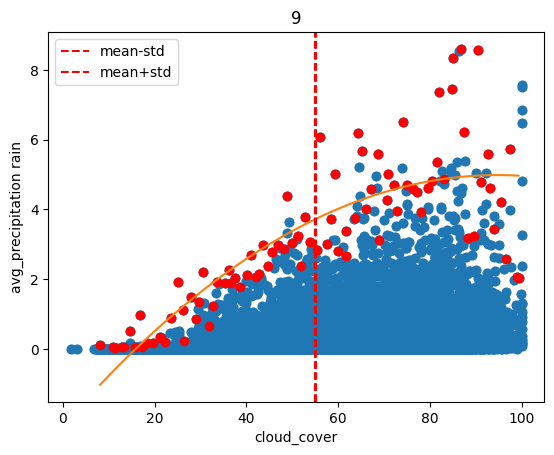

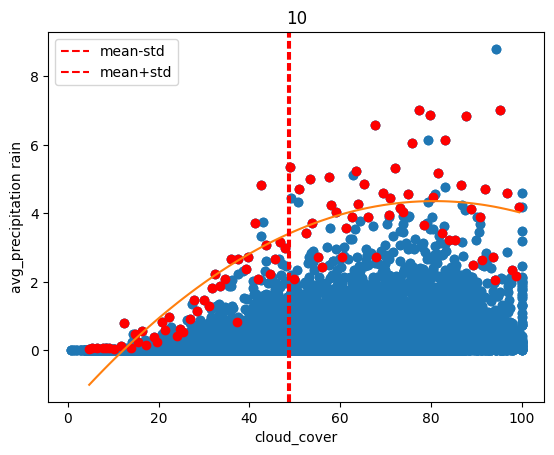

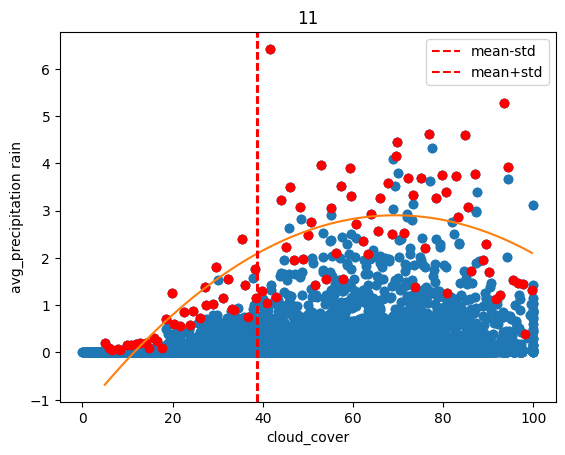

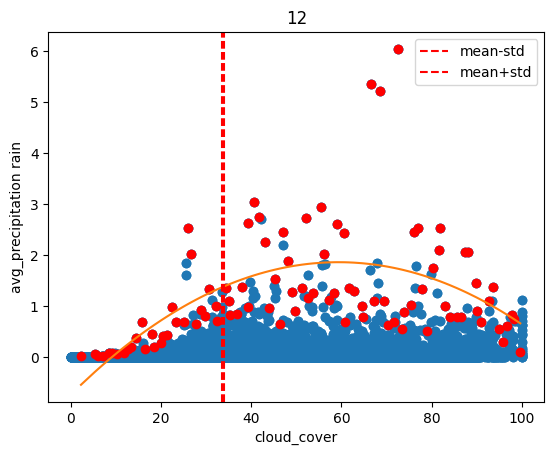

In [0]:
for i in range(1,13):
    month_rain = bkk_rain.filter(col('month') == i)
    xs = [val.cloud_cover for val in month_rain.select('cloud_cover').collect()]
    ys = [val.precipitation for val in month_rain.select('precipitation').collect()]
    zip_xy = list(filter(remove_none,list(zip(xs,ys))))
    xs = []
    ys = []

    for z in zip_xy:
        xs.append(z[0])
        ys.append(z[1])
    zip_xy.sort(key=lambda tup: tup[0])
    filtered = list(filter(rem_0,max_slice(zip_xy, 0, 100, 1, 6)))
    filtered_x = []
    filtered_y = []

    plt.title(i)
 
    for i in filtered:
        filtered_x.append(i[0])
        filtered_y.append(i[1])
    filtered_x = np.array(filtered_x)
    filtered_y = np.array(filtered_y)
    plt.plot(xs, ys, 'o')
    plt.plot(filtered_x, filtered_y, 'o', c='r')
    plt.xlabel('cloud_cover')
    plt.ylabel('avg_precipitation rain')
    popt, pcov = curve_fit(quadratic, filtered_x, filtered_y)
    y_fit = quadratic(filtered_x, *popt)
    plt.plot(filtered_x, y_fit)  
    plt.scatter(xs, ys)
    mean_x = np.mean(xs)
    std_x = np.std(xs)
    plt.axvline(mean_x-std_x/np.sqrt(len(xs)), c='r', linestyle='--', label = 'mean-std')
    plt.axvline(mean_x+std_x/np.sqrt(len(xs)), c='r', linestyle='--', label = 'mean+std')
    plt.legend()
    plt.show()

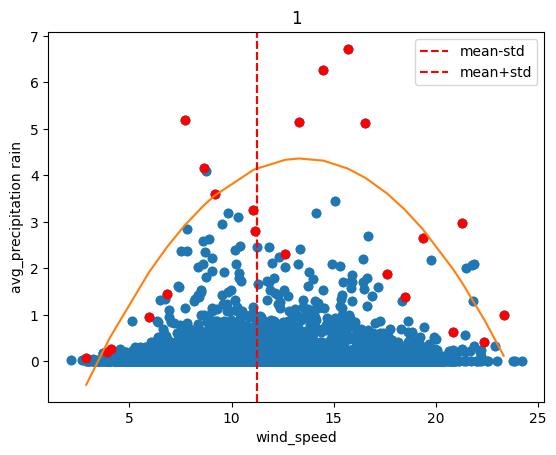

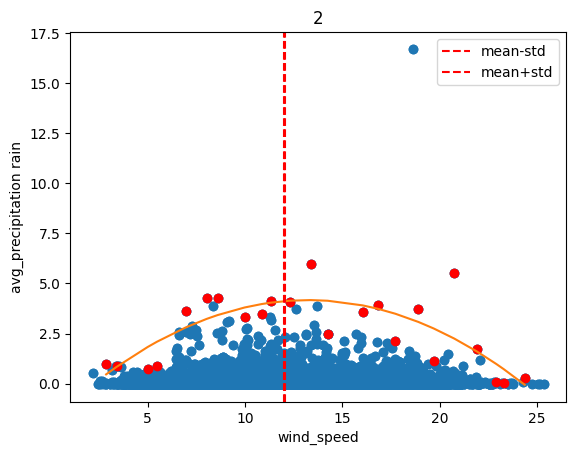

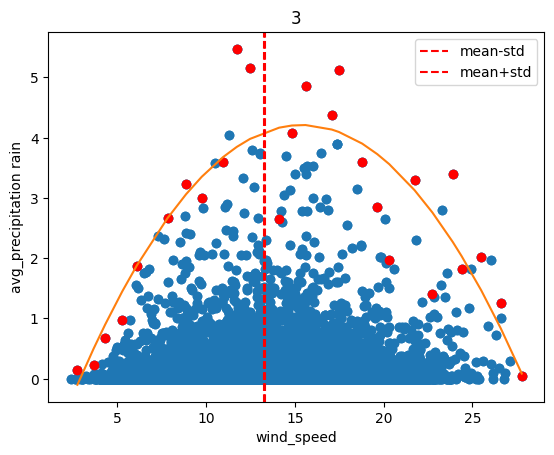

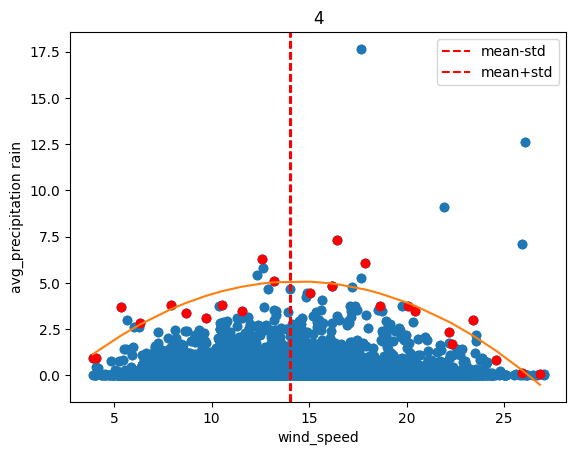

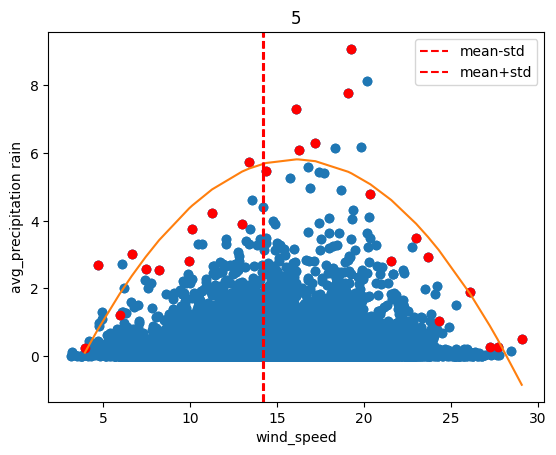

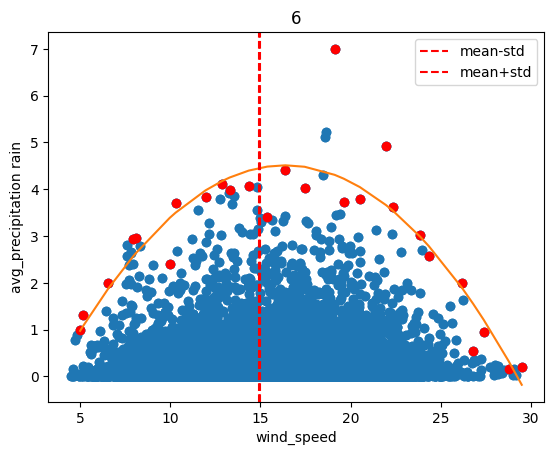

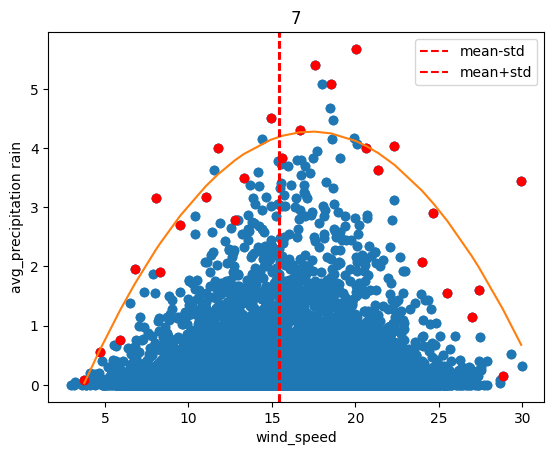

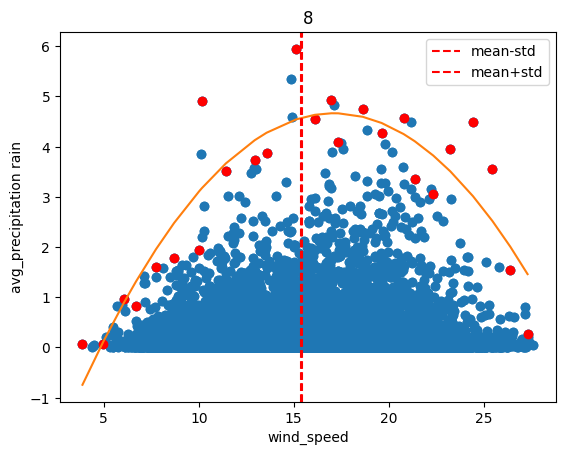

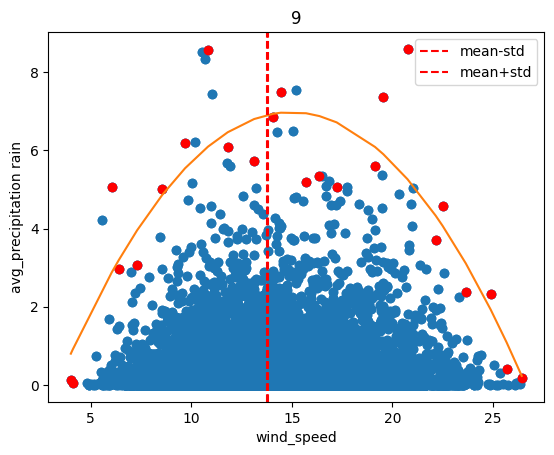

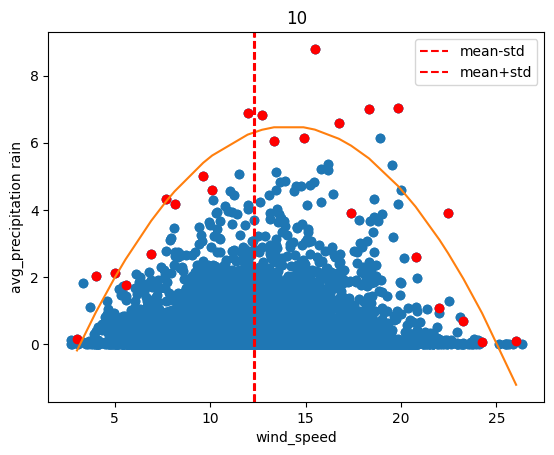

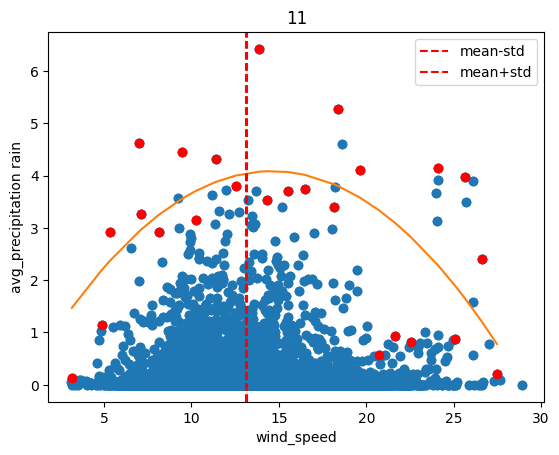

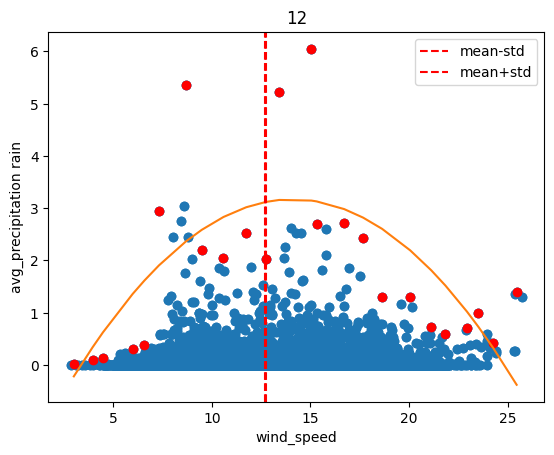

In [0]:
for i in range(1,13):
    month_rain = bkk_rain.filter(col('month') == i)
    xs = [val.wind_speed for val in month_rain.select('wind_speed').collect()]
    ys = [val.precipitation for val in month_rain.select('precipitation').collect()]
    zip_xy = list(filter(remove_none,list(zip(xs,ys))))
    xs = []
    ys = []

    for z in zip_xy:
        xs.append(z[0])
        ys.append(z[1])
    
    zip_xy.sort(key=lambda tup: tup[0])
    filtered = list(filter(rem_0,max_slice(zip_xy, 0, 100, 1, 6)))
    filtered_x = []
    filtered_y = []

    plt.title(i)
 
    for i in filtered:
        filtered_x.append(i[0])
        filtered_y.append(i[1])
    filtered_x = np.array(filtered_x)
    filtered_y = np.array(filtered_y)
    plt.plot(xs, ys, 'o')
    plt.plot(filtered_x, filtered_y, 'o', c='r')
    plt.xlabel('wind_speed')
    plt.ylabel('avg_precipitation rain')
    popt, pcov = curve_fit(quadratic, filtered_x, filtered_y)
    y_fit = quadratic(filtered_x, *popt)
    plt.plot(filtered_x, y_fit)  
    plt.scatter(xs, ys)
    mean_x = np.mean(xs)
    std_x = np.std(xs)
    plt.axvline(mean_x-std_x/np.sqrt(len(xs)), c='r', linestyle='--', label = 'mean-std')
    plt.axvline(mean_x+std_x/np.sqrt(len(xs)), c='r', linestyle='--', label = 'mean+std')
    plt.legend()
    plt.show()